In [1]:
import importlib
import emoDB
import ravdess
importlib.reload(emoDB)
importlib.reload(ravdess)
import torch
import torch.nn as nn
import torchaudio
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from emoDB import EmodbDataset
from torch.nn.utils.rnn import pad_sequence
from torch import cuda
import torch.optim as optim
from ravdess import RavdessDataset
from tqdm import tqdm

In [2]:
def emodb_collate_fn(batch):
    waveforms = [item['waveform'] for item in batch]
    sample_rates = [item['sample_rate'] for item in batch]
    emotions = [item['emotion'] for item in batch]

    # Find max length in waveforms
    max_length = max([waveform.size(1) for waveform in waveforms])

    # Pad all waveforms to max_length
    waveforms_padded = []
    for waveform in waveforms:
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        pad_amount = max_length - waveform.size(1)
        waveform_padded = torch.nn.functional.pad(waveform, (0, pad_amount))
        waveforms_padded.append(waveform_padded)
    # Stack everything up
    
    waveforms_padded = torch.stack(waveforms_padded)
    sample_rates = torch.stack([torch.tensor(sr) for sr in sample_rates])
    emotions = torch.stack([torch.tensor(em) for em in emotions])

    # Create attention mask
    #attention_masks_padded = torch.where(waveforms_padded != 0, 1, 0)
    attention_masks_padded = (waveforms_padded != 0)
    return waveforms_padded, sample_rates, emotions, attention_masks_padded

In [3]:
BATCH_SIZE = 4
EMO_CLASSES = 7
RAVDESS_CLASSES = 8

In [4]:
emoDB = EmodbDataset('./emoDB/')

c:\UCLA\cs260\realproject\emoDB.py:36: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['speaker_id', 'code', 'emotion', 'version', 'file'], dtype=np.float32)


In [5]:
from torch.utils.data import random_split

# Let's say you want to use 80% of the data for training, and 20% for testing
emodb_train_size = int(0.2 * len(emoDB))
emodb_test_size = len(emoDB) - emodb_train_size

emodb_train_dataset, emodb_test_dataset = random_split(emoDB, [emodb_train_size, emodb_test_size])


emodb_train_loader = DataLoader(emodb_train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=emodb_collate_fn)
emodb_test_loader = DataLoader(emodb_test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=emodb_collate_fn)

In [6]:
ravdess = RavdessDataset('./ravdess/audio_speech_actors_01-24/')

c:\UCLA\cs260\realproject\ravdess.py:38: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  self.df = pd.DataFrame(data, columns=['modality', 'vocal_channel', 'emotion', 'intensity', 'statement', 'repetition', 'actor', 'file'], dtype=np.float32)


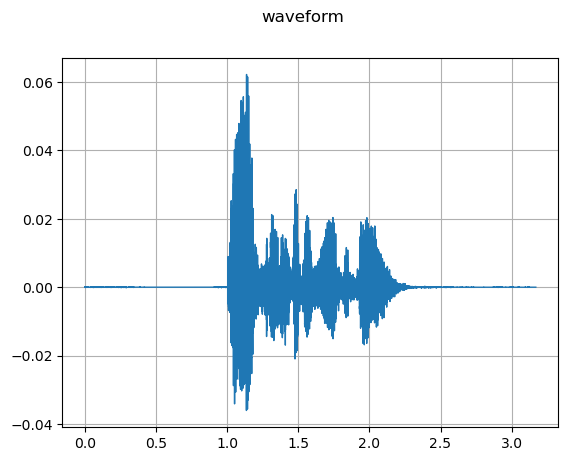

In [7]:
import matplotlib.pyplot as plt
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)
plot_waveform(ravdess[3]['waveform'], ravdess[3]['sample_rate'])

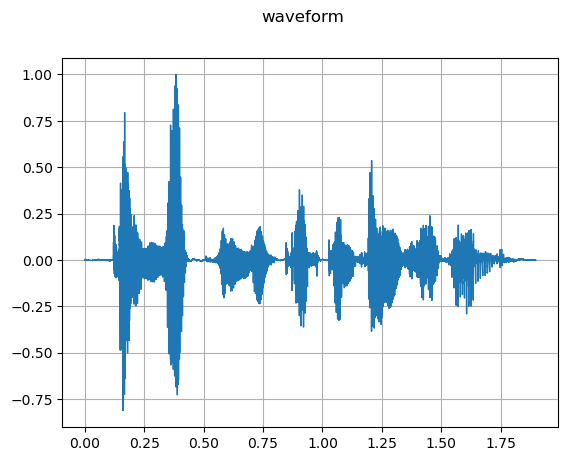

In [8]:
plot_waveform(emoDB[0]['waveform'], emoDB[0]['sample_rate'])

In [11]:
ravdess_train_size = int(0.8 * len(ravdess))
ravdess_test_size = len(ravdess) - ravdess_train_size
ravdess_train, ravdess_test = random_split(ravdess, [ravdess_train_size, ravdess_test_size])
ravdess_train_loader = DataLoader(ravdess_train, batch_size=4, shuffle=True, collate_fn=emodb_collate_fn)
ravdess_test_loader = DataLoader(ravdess_test, batch_size=4, shuffle=True, collate_fn=emodb_collate_fn) 

In [12]:
def test(model, test_dl):
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  total = 0
  correct = 0
  model.to(device)
  model.eval()
  with torch.no_grad():
    for X, rate, y, attention_mask in test_dl:
      X, y, attention_mask = X.to(device), y.to(device), attention_mask.to(device)
      outputs = model.forward(X)
      max, preds = torch.max(outputs.data,1)
      total += y.size(0)
      #print(preds)
      #print(y)
      correct += (preds == y).sum().item()
  accuracy = correct / total

  return accuracy

In [13]:
def train(model, lr, num_epochs, train_dl, test_dl):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(),lr=lr)
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        #i = 0
        for X, rate, y, attention_mask in tqdm(train_dl):
            #print(y.shape)
            #y = y.long()
            X, y, attention_mask = X.to(device), y.to(device), attention_mask.to(device)
            optimizer.zero_grad()
            #print(y.shape)
            #print(X.shape)
            #print(attention_mask.shape)
            #print(X.shape)
            #print(y)
            outputs = model(X)
            #print(outputs)
            #print("outputs ", outputs)
            #print("y ", y)
            loss = criterion(outputs, y)
            #print()
            loss.backward()

            #torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            """
            for name, parameter in model.named_parameters():
                if parameter.grad is not None:
                    print(f'{name}: gradient max {parameter.grad.data.abs().max()}, gradient min {parameter.grad.data.abs().min()}')
            """
            optimizer.step()

            running_loss += loss.item()
            #print(running_loss)
            _, preds = outputs.max(1)
            total += y.size(0)
            correct += (preds == y).sum().item()
            #if i%80 == 0:
                #print("current: ", 100.*correct/total)
            #i = i+1
        print(f"Epoch {epoch+1} | Loss: {running_loss / len(train_dl)} | Accuracy: {100.*correct/total}")
        test_accuracy = test(model,test_dl)
        print(f"Test Accuracy: {test_accuracy}")
        torch.cuda.empty_cache()



In [15]:
import models
importlib.reload(models)
from models import Baseline
from models import TransferModel
from models import ScratchModel

ravdess_model = torch.load('ravdess-12-2.pth')
test(ravdess_model,ravdess_test_loader)

0.9618055555555556

In [ ]:
import models
importlib.reload(models)
from models import Baseline
from models import TransferModel
from models import ScratchModel

hidden_layers = [6, 8, 10, 12]
frozens = [0.25, 0.5, 0.75]
for hidden_layer in hidden_layers:
    for frozen in frozens:
        frozen_layers = int(frozen*hidden_layer)
        print("model hidden layers: ", hidden_layer, " model frozen layers: ", frozen_layers)
        ravdess_transfer_model = TransferModel(RAVDESS_CLASSES, hidden_layers = hidden_layer, layers_frozen = frozen_layers)
        ravdess_scratch_model = ScratchModel(RAVDESS_CLASSES)

        lr = 0.00001
        num_epochs = 15
        train(ravdess_transfer_model, lr, num_epochs, ravdess_train_loader, ravdess_test_loader)

In [19]:
torch.save(ravdess_transfer_model, 'ravdess-12-2.pth')

In [65]:
importlib.reload(models)
from models import TransferredModel
emodb_transferred_model = TransferredModel(EMO_CLASSES,ravdess_transfer_model,freeze_all = True)
train(emodb_transferred_model,lr, 15, emodb_train_loader, emodb_test_loader)

cuda


100%|██████████| 27/27 [00:10<00:00,  2.52it/s]


Epoch 1 | Loss: 1.789881083700392 | Accuracy: 30.8411214953271
Test Accuracy: 0.7079439252336449


100%|██████████| 27/27 [00:16<00:00,  1.63it/s]


Epoch 2 | Loss: 1.3407044763918277 | Accuracy: 68.22429906542057
Test Accuracy: 0.8177570093457944


100%|██████████| 27/27 [00:16<00:00,  1.66it/s]


Epoch 3 | Loss: 1.1182556351025899 | Accuracy: 75.70093457943925
Test Accuracy: 0.9182242990654206


100%|██████████| 27/27 [00:10<00:00,  2.53it/s]


Epoch 4 | Loss: 0.9754455111644886 | Accuracy: 87.85046728971963
Test Accuracy: 0.969626168224299


100%|██████████| 27/27 [00:11<00:00,  2.27it/s]


Epoch 5 | Loss: 0.6931899896374455 | Accuracy: 90.65420560747664
Test Accuracy: 0.969626168224299


100%|██████████| 27/27 [00:11<00:00,  2.36it/s]


Epoch 6 | Loss: 0.5375499261750115 | Accuracy: 96.26168224299066
Test Accuracy: 0.9836448598130841


100%|██████████| 27/27 [00:12<00:00,  2.16it/s]


Epoch 7 | Loss: 0.4544362365095704 | Accuracy: 94.39252336448598
Test Accuracy: 0.985981308411215


100%|██████████| 27/27 [00:11<00:00,  2.32it/s]


Epoch 8 | Loss: 0.47919747012632863 | Accuracy: 94.39252336448598
Test Accuracy: 0.9579439252336449


100%|██████████| 27/27 [00:11<00:00,  2.43it/s]


Epoch 9 | Loss: 0.4637548937289803 | Accuracy: 95.32710280373831
Test Accuracy: 0.9766355140186916


100%|██████████| 27/27 [00:10<00:00,  2.63it/s]


Epoch 10 | Loss: 0.40782829374074936 | Accuracy: 98.13084112149532
Test Accuracy: 0.9742990654205608


100%|██████████| 27/27 [00:11<00:00,  2.38it/s]


Epoch 11 | Loss: 0.3303731925509594 | Accuracy: 98.13084112149532
Test Accuracy: 0.969626168224299


100%|██████████| 27/27 [00:07<00:00,  3.42it/s]


Epoch 12 | Loss: 0.49725877548809405 | Accuracy: 94.39252336448598
Test Accuracy: 0.9579439252336449


100%|██████████| 27/27 [00:08<00:00,  3.09it/s]


Epoch 13 | Loss: 0.2716954783708961 | Accuracy: 99.06542056074767
Test Accuracy: 0.9649532710280374


100%|██████████| 27/27 [00:10<00:00,  2.52it/s]


Epoch 14 | Loss: 0.34824140425081607 | Accuracy: 96.26168224299066
Test Accuracy: 0.985981308411215


100%|██████████| 27/27 [00:10<00:00,  2.70it/s]


Epoch 15 | Loss: 0.2915677236462081 | Accuracy: 98.13084112149532
Test Accuracy: 0.985981308411215


In [19]:
import models
importlib.reload(models)
from models import Baseline
from models import TransferModel
from models import ScratchModel
emodb_base_model = TransferModel(EMO_CLASSES, layers_frozen = 2)
lr= 0.00001
train(emodb_base_model,lr, 15, emodb_train_loader, emodb_test_loader)

cuda


100%|██████████| 27/27 [00:04<00:00,  5.75it/s]


Epoch 1 | Loss: 1.9157711885593556 | Accuracy: 20.560747663551403
Test Accuracy: 0.24299065420560748


100%|██████████| 27/27 [00:04<00:00,  5.41it/s]


Epoch 2 | Loss: 1.8355473589014124 | Accuracy: 28.037383177570092
Test Accuracy: 0.2827102803738318


100%|██████████| 27/27 [00:04<00:00,  5.53it/s]


Epoch 3 | Loss: 1.7185949352052476 | Accuracy: 25.233644859813083
Test Accuracy: 0.32009345794392524


100%|██████████| 27/27 [00:03<00:00,  7.93it/s]


Epoch 4 | Loss: 1.6105833760014288 | Accuracy: 43.925233644859816
Test Accuracy: 0.45093457943925236


100%|██████████| 27/27 [00:03<00:00,  7.68it/s]


Epoch 5 | Loss: 1.4864535287574485 | Accuracy: 53.271028037383175
Test Accuracy: 0.4135514018691589


100%|██████████| 27/27 [00:04<00:00,  6.21it/s]


Epoch 6 | Loss: 1.3022024476969685 | Accuracy: 56.074766355140184
Test Accuracy: 0.5116822429906542


100%|██████████| 27/27 [00:03<00:00,  7.72it/s]


Epoch 7 | Loss: 1.213749920880353 | Accuracy: 58.87850467289719
Test Accuracy: 0.6051401869158879


100%|██████████| 27/27 [00:04<00:00,  6.04it/s]


Epoch 8 | Loss: 1.0922249677004638 | Accuracy: 74.76635514018692
Test Accuracy: 0.6285046728971962


100%|██████████| 27/27 [00:05<00:00,  4.53it/s]


Epoch 9 | Loss: 1.0034588774045308 | Accuracy: 74.76635514018692
Test Accuracy: 0.6962616822429907


100%|██████████| 27/27 [00:13<00:00,  2.07it/s]


Epoch 10 | Loss: 0.9545430154712112 | Accuracy: 75.70093457943925
Test Accuracy: 0.7453271028037384


100%|██████████| 27/27 [00:05<00:00,  4.95it/s]


Epoch 11 | Loss: 0.6740918545811264 | Accuracy: 87.85046728971963
Test Accuracy: 0.7710280373831776


100%|██████████| 27/27 [00:08<00:00,  3.20it/s]


Epoch 12 | Loss: 0.7005740095067907 | Accuracy: 82.24299065420561
Test Accuracy: 0.7313084112149533


100%|██████████| 27/27 [00:04<00:00,  6.51it/s]


Epoch 13 | Loss: 0.6060026243880943 | Accuracy: 90.65420560747664
Test Accuracy: 0.7616822429906542


100%|██████████| 27/27 [00:07<00:00,  3.56it/s]


Epoch 14 | Loss: 0.49304764138327706 | Accuracy: 94.39252336448598
Test Accuracy: 0.8317757009345794


100%|██████████| 27/27 [00:04<00:00,  5.58it/s]


Epoch 15 | Loss: 0.5105676579254644 | Accuracy: 93.45794392523365
Test Accuracy: 0.7780373831775701


In [20]:
train(emodb_base_model,lr, 5, emodb_train_loader, emodb_test_loader)

cuda


100%|██████████| 27/27 [00:05<00:00,  5.15it/s]


Epoch 1 | Loss: 0.483000109869021 | Accuracy: 92.5233644859813
Test Accuracy: 0.822429906542056


100%|██████████| 27/27 [00:05<00:00,  5.20it/s]


Epoch 2 | Loss: 0.26084984480230894 | Accuracy: 96.26168224299066
Test Accuracy: 0.8271028037383178


100%|██████████| 27/27 [00:07<00:00,  3.48it/s]


Epoch 3 | Loss: 0.359698157619547 | Accuracy: 96.26168224299066
Test Accuracy: 0.8621495327102804


100%|██████████| 27/27 [00:04<00:00,  5.95it/s]


Epoch 4 | Loss: 0.32053450577788883 | Accuracy: 97.19626168224299
Test Accuracy: 0.7476635514018691


100%|██████████| 27/27 [00:05<00:00,  4.84it/s]


Epoch 5 | Loss: 0.3733572844001982 | Accuracy: 94.39252336448598
Test Accuracy: 0.8247663551401869


In [70]:
emodb_scratch_model = ScratchModel(EMO_CLASSES)
train(emodb_scratch_model,lr,20,emodb_train_loader,emodb_test_loader)

cuda


100%|██████████| 107/107 [01:55<00:00,  1.08s/it]


Epoch 1 | Loss: 1.7824313245087027 | Accuracy: 31.30841121495327
Test Accuracy: 0.34579439252336447


100%|██████████| 107/107 [02:16<00:00,  1.28s/it]


Epoch 2 | Loss: 1.3543661637840985 | Accuracy: 46.96261682242991
Test Accuracy: 0.38317757009345793


100%|██████████| 107/107 [01:43<00:00,  1.03it/s]


Epoch 3 | Loss: 1.1526673113074257 | Accuracy: 55.60747663551402
Test Accuracy: 0.4392523364485981


100%|██████████| 107/107 [01:48<00:00,  1.01s/it]


Epoch 4 | Loss: 1.096064887731989 | Accuracy: 57.71028037383178
Test Accuracy: 0.42990654205607476


100%|██████████| 107/107 [02:00<00:00,  1.13s/it]


Epoch 5 | Loss: 1.087185400111653 | Accuracy: 55.60747663551402
Test Accuracy: 0.411214953271028


100%|██████████| 107/107 [02:56<00:00,  1.65s/it]


Epoch 6 | Loss: 0.9679558424749107 | Accuracy: 62.850467289719624
Test Accuracy: 0.411214953271028


100%|██████████| 107/107 [02:17<00:00,  1.28s/it]


Epoch 7 | Loss: 1.0093646829373368 | Accuracy: 56.308411214953274
Test Accuracy: 0.4953271028037383


100%|██████████| 107/107 [02:01<00:00,  1.14s/it]


Epoch 8 | Loss: 0.890213325201908 | Accuracy: 64.95327102803738
Test Accuracy: 0.411214953271028


100%|██████████| 107/107 [02:23<00:00,  1.34s/it]


Epoch 9 | Loss: 0.8802555596159998 | Accuracy: 65.18691588785046
Test Accuracy: 0.48598130841121495


100%|██████████| 107/107 [02:12<00:00,  1.24s/it]


Epoch 10 | Loss: 0.8381604105234146 | Accuracy: 65.42056074766356
Test Accuracy: 0.4953271028037383


100%|██████████| 107/107 [02:13<00:00,  1.24s/it]


Epoch 11 | Loss: 0.7516477674802887 | Accuracy: 71.02803738317758
Test Accuracy: 0.4953271028037383


100%|██████████| 107/107 [02:13<00:00,  1.25s/it]


Epoch 12 | Loss: 0.6949749341077893 | Accuracy: 73.59813084112149
Test Accuracy: 0.5420560747663551


100%|██████████| 107/107 [02:12<00:00,  1.24s/it]


Epoch 13 | Loss: 0.605679971870975 | Accuracy: 77.10280373831776
Test Accuracy: 0.38317757009345793


100%|██████████| 107/107 [02:48<00:00,  1.57s/it]


Epoch 14 | Loss: 0.5935956443024573 | Accuracy: 75.46728971962617
Test Accuracy: 0.5046728971962616


100%|██████████| 107/107 [02:06<00:00,  1.19s/it]


Epoch 15 | Loss: 0.5200708182267496 | Accuracy: 79.67289719626169
Test Accuracy: 0.4485981308411215


100%|██████████| 107/107 [02:10<00:00,  1.22s/it]


Epoch 16 | Loss: 0.4724420141602788 | Accuracy: 80.8411214953271
Test Accuracy: 0.5607476635514018


100%|██████████| 107/107 [02:31<00:00,  1.41s/it]


Epoch 17 | Loss: 0.43164650305548563 | Accuracy: 83.41121495327103
Test Accuracy: 0.5700934579439252


100%|██████████| 107/107 [02:19<00:00,  1.30s/it]


Epoch 18 | Loss: 0.3931332460526272 | Accuracy: 86.91588785046729
Test Accuracy: 0.34579439252336447


100%|██████████| 107/107 [02:10<00:00,  1.22s/it]


Epoch 19 | Loss: 0.32321071640422966 | Accuracy: 88.08411214953271
Test Accuracy: 0.5794392523364486


100%|██████████| 107/107 [02:22<00:00,  1.33s/it]


Epoch 20 | Loss: 0.2747981063281752 | Accuracy: 90.42056074766356
Test Accuracy: 0.5514018691588785


In [44]:
import urdu
importlib.reload(urdu)
from urdu import UrduDataset
UrduData = UrduDataset("./URDU-Dataset-master/")
URDU_CLASSES = 4

c:\UCLA\cs260\realproject\urdu.py:37: FutureWarning: Could not cast to float32, falling back to object. This behavior is deprecated. In a future version, when a dtype is passed to 'DataFrame', either all columns will be cast to that dtype, or a TypeError will be raised.
  # Map emotion labels to numeric values


In [60]:
urdu_train_size = int(0.8 * len(UrduData))
urdu_test_size = len(UrduData) - urdu_train_size
urdu_train, urdu_test = random_split(UrduData, [urdu_train_size, urdu_test_size])
urdu_train_loader = DataLoader(urdu_train, batch_size=4, shuffle=True, collate_fn=emodb_collate_fn)
urdu_test_loader = DataLoader(urdu_test, batch_size=4, shuffle=True, collate_fn=emodb_collate_fn) 

In [57]:
import models
importlib.reload(models)
from models import Baseline
from models import TransferModel
from models import TransferredModel
from models import ScratchModel
urdu_transferred_model = TransferredModel(URDU_CLASSES,ravdess_transfer_model,freeze_all = True)
train(urdu_transferred_model,lr, 10, urdu_train_loader, urdu_test_loader)

cuda


100%|██████████| 20/20 [00:02<00:00,  8.16it/s]


Epoch 1 | Loss: 1.0167117238044738 | Accuracy: 80.0
Test Accuracy: 0.915625


100%|██████████| 20/20 [00:02<00:00,  8.97it/s]


Epoch 2 | Loss: 0.6926862537860871 | Accuracy: 88.75
Test Accuracy: 0.91875


100%|██████████| 20/20 [00:02<00:00,  7.94it/s]


Epoch 3 | Loss: 0.33336782455444336 | Accuracy: 100.0
Test Accuracy: 0.928125


100%|██████████| 20/20 [00:02<00:00,  8.71it/s]


Epoch 4 | Loss: 0.39127003140747546 | Accuracy: 93.75
Test Accuracy: 0.934375


100%|██████████| 20/20 [00:02<00:00,  9.18it/s]


Epoch 5 | Loss: 0.5749627832323313 | Accuracy: 90.0
Test Accuracy: 0.921875


100%|██████████| 20/20 [00:02<00:00,  8.30it/s]


Epoch 6 | Loss: 0.2134445421397686 | Accuracy: 100.0
Test Accuracy: 0.940625


100%|██████████| 20/20 [00:02<00:00,  8.52it/s]


Epoch 7 | Loss: 0.1892389001324773 | Accuracy: 100.0
Test Accuracy: 0.9375


100%|██████████| 20/20 [00:02<00:00,  8.65it/s]


Epoch 8 | Loss: 0.16448111906647683 | Accuracy: 100.0
Test Accuracy: 0.940625


100%|██████████| 20/20 [00:02<00:00,  8.64it/s]


Epoch 9 | Loss: 0.12238182183355092 | Accuracy: 100.0
Test Accuracy: 0.940625


100%|██████████| 20/20 [00:02<00:00,  8.83it/s]


Epoch 10 | Loss: 0.10687941666692495 | Accuracy: 97.5
Test Accuracy: 0.9375


In [59]:
urdu_transfer_model = TransferModel(URDU_CLASSES, layers_frozen = 2)
train(urdu_transfer_model,lr, 10, urdu_train_loader, urdu_test_loader)

cuda


100%|██████████| 20/20 [00:02<00:00,  8.29it/s]


Epoch 1 | Loss: 1.3755382120609283 | Accuracy: 31.25
Test Accuracy: 0.321875


100%|██████████| 20/20 [00:02<00:00,  8.38it/s]


Epoch 2 | Loss: 1.3322503924369813 | Accuracy: 47.5
Test Accuracy: 0.371875


100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch 3 | Loss: 1.277250772714615 | Accuracy: 58.75
Test Accuracy: 0.45


100%|██████████| 20/20 [00:02<00:00,  8.43it/s]


Epoch 4 | Loss: 1.1969132512807845 | Accuracy: 61.25
Test Accuracy: 0.553125


100%|██████████| 20/20 [00:02<00:00,  8.68it/s]


Epoch 5 | Loss: 1.1435007363557816 | Accuracy: 73.75
Test Accuracy: 0.75


100%|██████████| 20/20 [00:02<00:00,  8.11it/s]


Epoch 6 | Loss: 0.8993585407733917 | Accuracy: 87.5
Test Accuracy: 0.79375


100%|██████████| 20/20 [00:02<00:00,  8.89it/s]


Epoch 7 | Loss: 0.7071630045771599 | Accuracy: 85.0
Test Accuracy: 0.80625


100%|██████████| 20/20 [00:02<00:00,  8.50it/s]


Epoch 8 | Loss: 0.49847642332315445 | Accuracy: 88.75
Test Accuracy: 0.775


100%|██████████| 20/20 [00:02<00:00,  8.60it/s]


Epoch 9 | Loss: 0.4510936588048935 | Accuracy: 87.5
Test Accuracy: 0.83125


100%|██████████| 20/20 [00:02<00:00,  8.42it/s]


Epoch 10 | Loss: 0.313440702483058 | Accuracy: 91.25
Test Accuracy: 0.828125


In [61]:
urdu_scratch_model = ScratchModel(URDU_CLASSES)
train(urdu_scratch_model,lr, 20, urdu_train_loader, urdu_test_loader)

cuda


100%|██████████| 80/80 [00:06<00:00, 11.65it/s]


Epoch 1 | Loss: 1.28392037153244 | Accuracy: 38.125
Test Accuracy: 0.4125


100%|██████████| 80/80 [00:06<00:00, 11.93it/s]


Epoch 2 | Loss: 0.9878448419272899 | Accuracy: 61.875
Test Accuracy: 0.4875


100%|██████████| 80/80 [00:06<00:00, 12.04it/s]


Epoch 3 | Loss: 0.8387296970933675 | Accuracy: 66.875
Test Accuracy: 0.675


100%|██████████| 80/80 [00:06<00:00, 12.05it/s]


Epoch 4 | Loss: 0.7469855640083551 | Accuracy: 71.25
Test Accuracy: 0.575


100%|██████████| 80/80 [00:06<00:00, 12.05it/s]


Epoch 5 | Loss: 0.6978504025377333 | Accuracy: 71.875
Test Accuracy: 0.6625


100%|██████████| 80/80 [00:06<00:00, 12.14it/s]


Epoch 6 | Loss: 0.5773901556152851 | Accuracy: 77.1875
Test Accuracy: 0.6875


100%|██████████| 80/80 [00:06<00:00, 11.79it/s]


Epoch 7 | Loss: 0.45405976539477705 | Accuracy: 85.3125
Test Accuracy: 0.675


100%|██████████| 80/80 [00:06<00:00, 11.77it/s]


Epoch 8 | Loss: 0.4736931866733357 | Accuracy: 84.6875
Test Accuracy: 0.5


100%|██████████| 80/80 [00:06<00:00, 11.70it/s]


Epoch 9 | Loss: 0.39734400501474737 | Accuracy: 87.1875
Test Accuracy: 0.7375


100%|██████████| 80/80 [00:06<00:00, 11.85it/s]


Epoch 10 | Loss: 0.3209002616815269 | Accuracy: 86.25
Test Accuracy: 0.75


100%|██████████| 80/80 [00:06<00:00, 11.65it/s]


Epoch 11 | Loss: 0.2970979442296084 | Accuracy: 90.3125
Test Accuracy: 0.7125


100%|██████████| 80/80 [00:07<00:00, 11.28it/s]


Epoch 12 | Loss: 0.21485213856212795 | Accuracy: 92.8125
Test Accuracy: 0.7125


100%|██████████| 80/80 [00:06<00:00, 11.53it/s]


Epoch 13 | Loss: 0.21508339789870662 | Accuracy: 92.8125
Test Accuracy: 0.725


100%|██████████| 80/80 [00:06<00:00, 11.65it/s]


Epoch 14 | Loss: 0.23410731958210818 | Accuracy: 91.5625
Test Accuracy: 0.625


100%|██████████| 80/80 [00:06<00:00, 12.33it/s]


Epoch 15 | Loss: 0.12257000792742474 | Accuracy: 96.25
Test Accuracy: 0.775


100%|██████████| 80/80 [00:06<00:00, 12.34it/s]


Epoch 16 | Loss: 0.086290053515404 | Accuracy: 98.125
Test Accuracy: 0.6375


100%|██████████| 80/80 [00:06<00:00, 12.20it/s]


Epoch 17 | Loss: 0.07356171917490428 | Accuracy: 97.5
Test Accuracy: 0.7375


100%|██████████| 80/80 [00:06<00:00, 12.31it/s]


Epoch 18 | Loss: 0.16099833824091547 | Accuracy: 94.375
Test Accuracy: 0.65


100%|██████████| 80/80 [00:06<00:00, 12.33it/s]


Epoch 19 | Loss: 0.10632822069101167 | Accuracy: 96.5625
Test Accuracy: 0.7


100%|██████████| 80/80 [00:06<00:00, 12.27it/s]


Epoch 20 | Loss: 0.054562079432616886 | Accuracy: 98.4375
Test Accuracy: 0.675
